## Name: Debasish Mondal

## Problem Statement 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Step 1: Importing all the Necessary Libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL

from google.colab import drive

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D

### Step 2: Data Reading/Data Understanding

In [ ]:
# Mounting the google drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# The path for train and test data
data_train = pathlib.Path("/content/drive/MyDrive/Skin_Cancer_Dataset/Train")
data_test = pathlib.Path("/content/drive/MyDrive/Skin_Cancer_Dataset/Test")

In [ ]:
# No. of images in the train data
image_count_train = len(list(data_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [ ]:
# No. of images in the test data
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

118


### Step 3: Dataset Creation

In [ ]:
# Parameters
batch_size = 32
img_height = 180
img_width = 180

#### We use 80% of the images for training and rest 20% for validation.

In [ ]:
# Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train, seed = 123, validation_split = 0.2, subset= 'training', 
                                                               image_size = (img_height, img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train, seed = 123, validation_split = 0.2, subset= 'validation', 
                                                             image_size = (img_height, img_width), batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# All the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Step 4: Dataset Visualisation

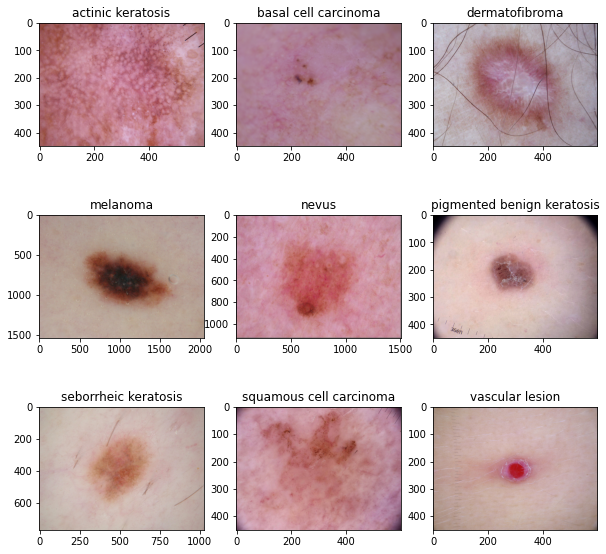

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_train.glob(class_names[i] + '/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Class Distribution in the Training Dataset

In [ ]:
# Dataframe with image count and class
def class_distribution_count(directory):
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))

    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
    return pd.DataFrame(list(zip(sub_directory, count)), columns = ['Class', 'No. of Image'])

In [ ]:
df = class_distribution_count(data_train)
df

,Class,No. of Image
0,melanoma,438
1,squamous cell carcinoma,181
2,dermatofibroma,95
3,basal cell carcinoma,376
4,nevus,357
5,actinic keratosis,114
6,vascular lesion,139
7,pigmented benign keratosis,462
8,seborrheic keratosis,77


### Auto-Tuning

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Step 4: Model Building & Training: 

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0, 1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`.

In [ ]:
# Model layers
num_classes = 9

# Rescaling Layer
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3))])

# 1st Convolution layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (180, 180, 32)))

# 2nd Convolution layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolution layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 4th Convolution layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 5th Convolution layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# Dropout layer
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())

# Dense Layer
model.add(Dense(num_classes, activation = "softmax"))

### Model Compilation

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

In [ ]:
# View the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Model Training

In [ ]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 558s 2s/step - loss: 2.0644 - accuracy: 0.1730 - val_loss: 2.0631 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 2.0376 - accuracy: 0.1864 - val_loss: 2.0281 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 2.0097 - accuracy: 0.1959 - val_loss: 1.9318 - val_accuracy: 0.2796
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9268 - accuracy: 0.2679 - val_loss: 1.8423 - val_accuracy: 0.3087
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9599 - accuracy: 0.2528 - val_loss: 1.8482 - val_accuracy: 0.3154
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.8254 - accuracy: 0.3069 - val_loss: 1.8202 - val_accuracy: 0.3087
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7493 - accuracy: 0.3493 - val_loss: 1.7348 - val_accuracy: 0.3557
Epoch 8/20
56/56 [======

### Visualizing Results

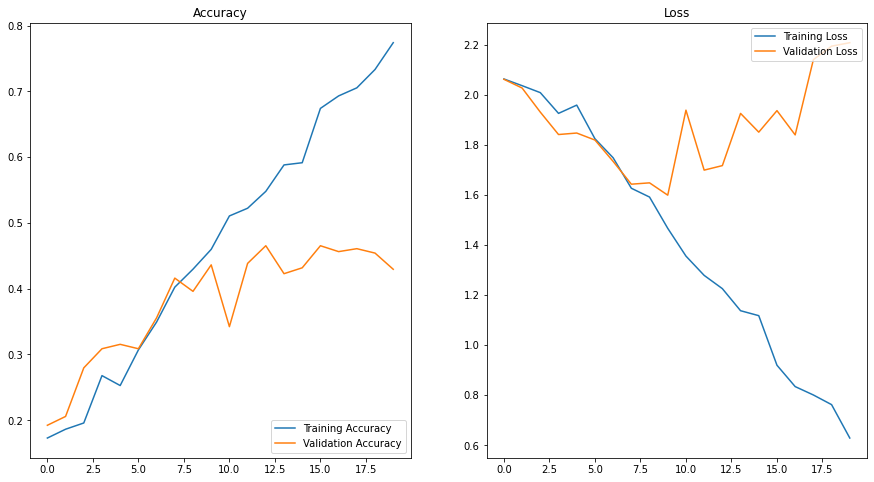

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss')
plt.show()

### Findings
The model is overfitting because we can also see difference in loss functions in training & validation around the 7th epoch.

### Step 5: Data Augmentation

In [ ]:
# Data augumentation strategy
data_augument = keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip(mode = "horizontal_and_vertical", input_shape = (img_height, img_width, 3)), 
     layers.experimental.preprocessing.RandomRotation(0.2, fill_mode = 'reflect'), 
     layers.experimental.preprocessing.RandomZoom(height_factor = (0.2, 0.3), width_factor = (0.2, 0.3), fill_mode = 'reflect')])

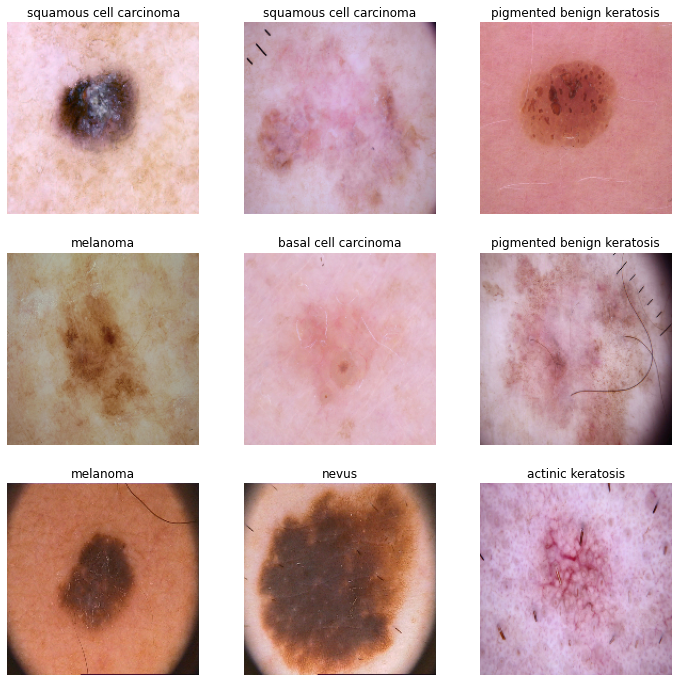

In [ ]:
# Data visualization
plt.figure(figsize = (12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Step 6: Model Building & Training


In [ ]:
# Model layers
# Rescaling Layer
model = Sequential([data_augument, layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3))])

# 1st Convolutional Layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (180, 180, 32)))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 4th Convolutional Layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5),padding = 'Same',  activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# Dropout Layer
model.add(Dropout(0.25))

# Flatten Layer
model.add(Flatten())

# Dense Layer
model.add(Dense(num_classes, activation = "softmax"))

### Model Compilation

In [ ]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

### Model Training

In [ ]:
epochs = 20
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/20
56/56 [==============================] - 8s 110ms/step - loss: 2.0617 - accuracy: 0.1864 - val_loss: 2.0267 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 6s 105ms/step - loss: 1.9913 - accuracy: 0.2282 - val_loss: 1.9211 - val_accuracy: 0.2461
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 1.9389 - accuracy: 0.2573 - val_loss: 1.8616 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 1.8488 - accuracy: 0.2991 - val_loss: 1.8257 - val_accuracy: 0.3423
Epoch 5/20
56/56 [==============================] - 6s 106ms/step - loss: 1.8120 - accuracy: 0.3214 - val_loss: 1.7665 - val_accuracy: 0.3289
Epoch 6/20
56/56 [==============================] - 6s 106ms/step - loss: 1.7615 - accuracy: 0.3454 - val_loss: 1.7848 - val_accuracy: 0.3669
Epoch 7/20
56/56 [==============================] - 6s 106ms/step - loss: 1.6451 - accuracy: 0.4062 - val_loss: 1.5694 - val_accuracy: 0.4430
Epoch 

### Visualizing Results

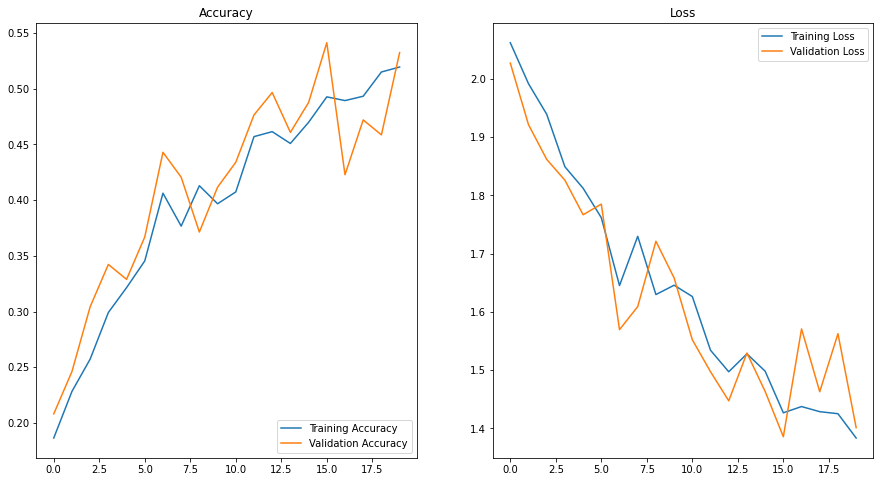

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss')
plt.show()

### Findings
The model accuracy is similar, but it is evident that the overfitting issue has been resolved as a result of data augmentation.

### Step 7: Class Distribution
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:   
    for j in data_train.glob(i + '/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()), columns = ['Path', 'Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
1,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
2,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
3,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
4,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion
2235,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion
2236,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion
2237,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion


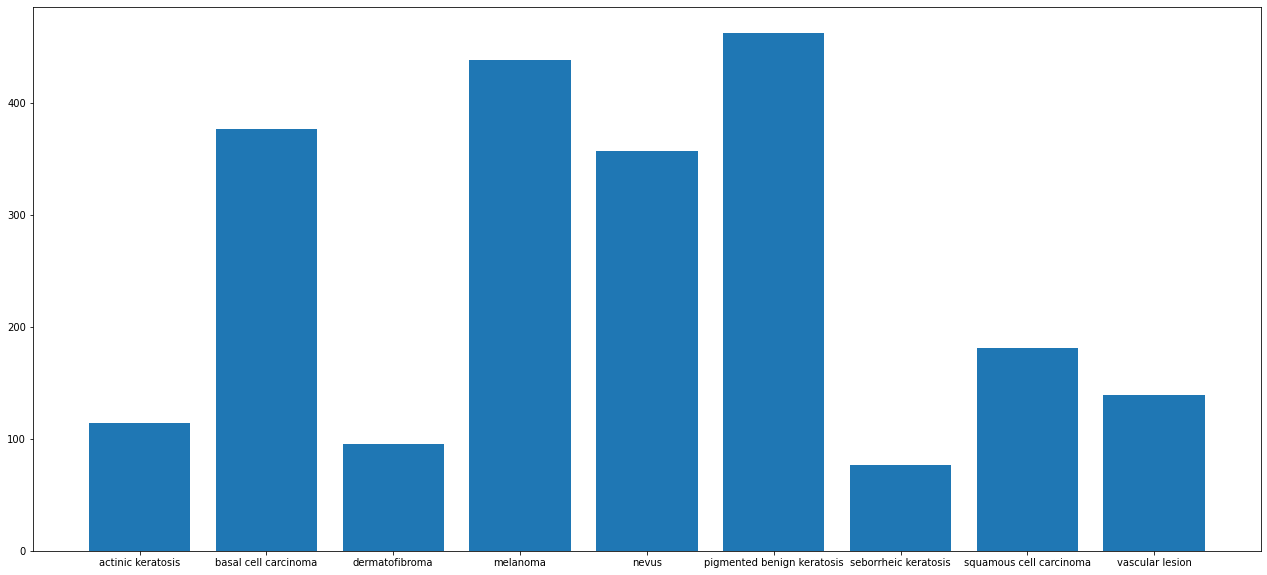

In [ ]:
count = []
for i in class_names:
    count.append(len(list(data_train.glob(i + '/*.jpg'))))
plt.figure(figsize = (22, 10))
plt.bar(class_names, count)
plt.show()

### Our Findings: 
### Which class has the least number of samples?
Answer: seborrheic keratosis.

### Which classes dominate the data in terms proportionate number of samples?
Answer: pigmented benign keratosis.

**melanoma and pigmented benign keratosis** have proprtionate number of classes.

### Step 8: Handling Class Imbalances

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset = "To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Skin_Cancer_Dataset/Train", save_format = 'jpg')
    p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)
    p.sample(500) # We are adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F44FF37E6D0>: 100%|██████████| 500/500 [00:40<00:00, 12.39 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F45002FF3D0>: 100%|██████████| 500/500 [00:52<00:00,  9.50 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F45026FCC40>: 100%|██████████| 500/500 [00:49<00:00, 10.06 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F458F0543A0>: 100%|██████████| 500/500 [01:03<00:00,  7.87 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4502E424C0>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F45026BF7F0>: 100%|██████████| 500/500 [00:47<00:00, 10.58 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F450291CD60>: 100%|██████████| 500/500 [00:46<00:00, 10.79 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4502E15490>: 100%|██████████| 500/500 [00:40<00:00, 12.39 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/drive/MyDrive/Skin_Cancer_Dataset/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F4502D83790>: 100%|██████████| 500/500 [00:49<00:00, 10.15 Samples/s]


In [ ]:
# Total count of augmented images
data_train1 = pathlib.Path("/content/drive/MyDrive/Skin_Cancer_Dataset/Train/output")
image_count_train1 = len(list(data_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [ ]:
for i in class_names:     
    for j in data_train1.glob(i + '/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
aug_df = pd.DataFrame(list(dataframe_dict_original.items()), columns = ['Path', 'Label'])
aug_df

,Path,Label
0,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
1,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
2,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
3,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
4,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,actinic keratosis
...,...,...
6734,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion
6735,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion
6736,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion
6737,/content/drive/MyDrive/Skin_Cancer_Dataset/Tra...,vascular lesion


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
aug_df['Label'].value_counts()

pigmented benign keratosis    1418
melanoma                      1271
basal cell carcinoma          1173
nevus                         1068
squamous cell carcinoma        537
vascular lesion                411
actinic keratosis              342
dermatofibroma                 283
seborrheic keratosis           236
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

### Step 9: Model Building & Training

In [ ]:
# Parameters
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Training dataset
data_train1 = "/content/drive/MyDrive/Skin_Cancer_Dataset/Train/output"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train1, seed = 123, validation_split = 0.2, 
                                                               subset = "training", image_size = (img_height, img_width), 
                                                               batch_size = batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [ ]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train1, seed = 123, validation_split = 0.2, 
                                                             subset = 'validation', image_size = (img_height, img_width), 
                                                             batch_size = batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Model Layers (Including Normalization)

In [ ]:
# Model layers
# Rescaling Layer
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3))])

# 1st Convolutional Layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))

# 2nd Convolutional Layer
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 4th Convolutional Layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 5th Convolutional Layer
model.add(Dropout(0.25))

# Flatten Layer
model.add(Flatten())

# Dense Layer
model.add(Dense(num_classes, activation = "softmax"))

### Model Compilation

In [ ]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics = ['accuracy'])

### Model Training

In [ ]:
epochs = 50
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/50
113/113 [==============================] - 23s 197ms/step - loss: 2.0439 - accuracy: 0.2097 - val_loss: 2.0367 - val_accuracy: 0.1922
Epoch 2/50
113/113 [==============================] - 22s 182ms/step - loss: 2.0283 - accuracy: 0.2053 - val_loss: 2.0154 - val_accuracy: 0.1911
Epoch 3/50
113/113 [==============================] - 22s 186ms/step - loss: 2.0222 - accuracy: 0.2022 - val_loss: 2.0150 - val_accuracy: 0.1911
Epoch 4/50
113/113 [==============================] - 22s 183ms/step - loss: 2.0167 - accuracy: 0.2033 - val_loss: 2.0152 - val_accuracy: 0.1911
Epoch 5/50
113/113 [==============================] - 21s 180ms/step - loss: 2.0121 - accuracy: 0.2133 - val_loss: 1.9976 - val_accuracy: 0.2011
Epoch 6/50
113/113 [==============================] - 22s 187ms/step - loss: 2.0057 - accuracy: 0.2178 - val_loss: 1.9920 - val_accuracy: 0.2111
Epoch 7/50
113/113 [==============================] - 21s 181ms/step - loss: 1.9966 - accuracy: 0.2350 - val_loss: 1.9812 - val_ac

### Visualizing Results

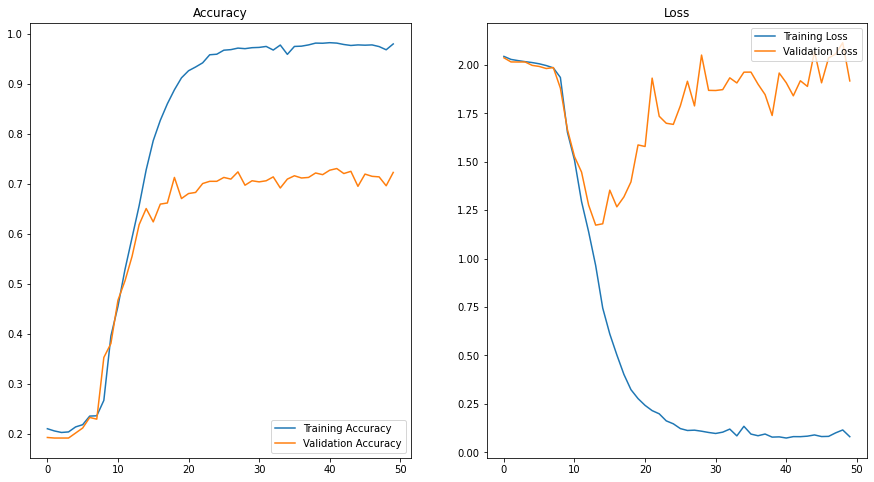

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize= (15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Loss')
plt.show()

### Step 10: Result Analysis
Did we get rid of underfitting/overfitting? Did class rebalance help?

Answer: Using the Augmentor library has improved the accuracy of the training data, but the model is still overfit. Increasing the number of layers or adjusting the hyperparameter can fix this.